# IBM Attrition Study

In [ ]:
# Téléchargement des données : Kaggle mot de passe et login

import urllib.request as ur
#ur.urlretrieve ("https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv"
#                , "WA_Fn-UseC_-HR-Employee-Attrition.zip")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from pylab import *


C:\Users\mlava\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
%matplotlib inline

In [5]:
df = pd.read_table("WA_Fn-UseC_-HR-Employee-Attrition.csv", sep = ",")

print(df.shape) # 35 variables
print(df.dtypes)
print(df.isnull().sum()) # pas de Missing Values

(1470, 35)
Age                          int64
Attrition                   object
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWork

# Preprocessing -Tentatives d'explications de certaines variables :

_On the structure:_
- We have 35 different variables : preprocessing needed to get rid of the useless variables (the ones with no correlation with Attrition)
- A lot of qalitative variables, we might lose a lot of information with PCA
- No missing values in this dataset

_On the datas themselves:_
- What do they represent?
    - HourlyRate, DailyRate, MonthlyRate
    - EmployeeCount
    - Over18


### HourlyRate, DailyRate, MonthlyRate

In [6]:
# Unité de mesure de HourlyRate ?
print(df["HourlyRate"].describe())

# HourlyRate en %
# Hypothèse la plus plausible : HourlyRate est un taux de performance par heure (ou efficacité)

count    1470.000000
mean       65.891156
std        20.329428
min        30.000000
25%        48.000000
50%        66.000000
75%        83.750000
max       100.000000
Name: HourlyRate, dtype: float64


In [7]:
print(df['DailyRate'].describe())

print(df['MonthlyRate'].describe())

count    1470.000000
mean      802.485714
std       403.509100
min       102.000000
25%       465.000000
50%       802.000000
75%      1157.000000
max      1499.000000
Name: DailyRate, dtype: float64
count     1470.000000
mean     14313.103401
std       7117.786044
min       2094.000000
25%       8047.000000
50%      14235.500000
75%      20461.500000
max      26999.000000
Name: MonthlyRate, dtype: float64


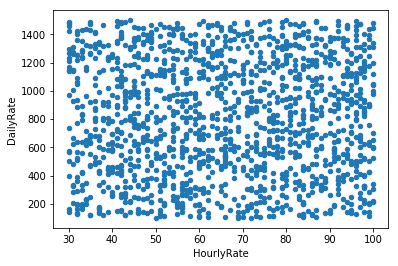

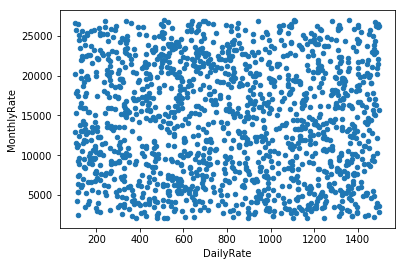

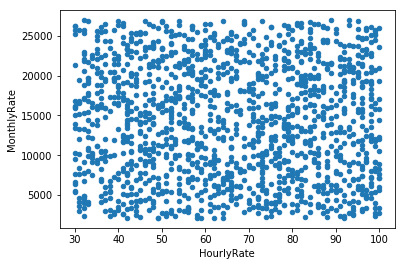

In [8]:
#Lien entre DailyRate, HourlyRate et MonthlyRate
df.plot(x = 'HourlyRate', y = 'DailyRate', kind = 'scatter')
df.plot(x = 'DailyRate', y = 'MonthlyRate', kind = 'scatter')
df.plot(x = 'HourlyRate', y = 'MonthlyRate', kind = 'scatter')

# Pas de relation linéaire entre les 3 variables 

In [9]:
# Unité de mesure de DailyRate?

# Hypothese 1: 802 = 8:02 ? en moyenne, fait sens
#mais min et max impossibles (1h/jour vs 14h/jour ?)

# Regardons s'il y a bien une corrélation avec OverTime
print(df["OverTime"].head())
print(df[df['OverTime']=='Yes']['DailyRate'].describe())

# Certaines personnes en Overtime travaillent toujours 1h/ jour : Hypothèse 1 rejetée

0    Yes
1     No
2    Yes
3    Yes
4     No
Name: OverTime, dtype: object
count     416.000000
mean      808.350962
std       407.262601
min       103.000000
25%       463.250000
50%       799.000000
75%      1171.750000
max      1498.000000
Name: DailyRate, dtype: float64


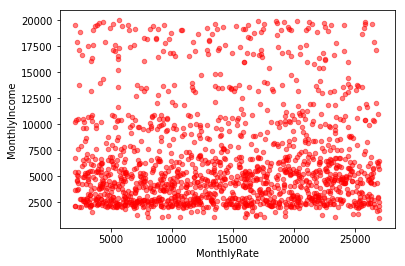

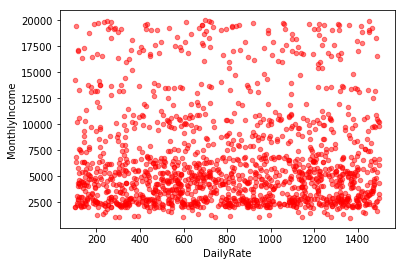

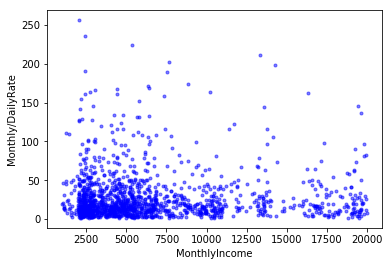

In [10]:
# Hypothèse 2: MonthlyRate et DailyRate sont liés au revenu par jour/par mois

df.plot(x = 'MonthlyRate', y = 'MonthlyIncome', kind = 'scatter', alpha = 0.5, color = 'red') # alpha = transparence
df.plot(x = 'DailyRate', y = 'MonthlyIncome', kind = 'scatter', alpha = 0.5, color = 'red') 

# pas de relation linéaire ici encore entre MonthlyIncome en fonction de MonthlyRate et MonthlyIncome en fonction de DailyRate
# Hypothèse 2 rejetée

#MonthlyRate et DailyRate ont le même comportement en fonction de MonthlyIncome
fig, ax = plt.subplots(1,1)
ax.plot(df['MonthlyIncome'], df['MonthlyRate']/df['DailyRate'], '.', alpha = 0.5, color = 'blue')
ax.set_xlabel("MonthlyIncome")
ax.set_ylabel('Monthly/DailyRate')
plt.show()

#Toujours pas de relation linéaire mais relation similaire à 1/x.... SIGNIFICATION ??

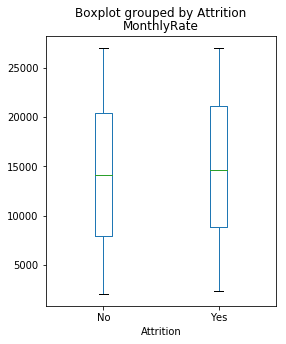

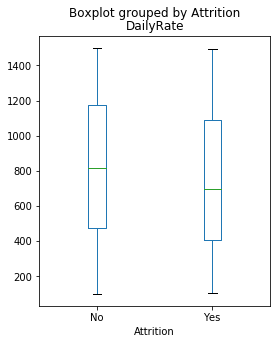

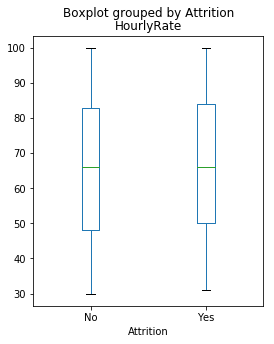

In [109]:
df.boxplot('MonthlyRate', by = 'Attrition', grid = False, figsize = (4,5))
df.boxplot('DailyRate', by = 'Attrition', grid = False, figsize = (4,5))
df.boxplot('HourlyRate', by = 'Attrition', grid = False, figsize = (4,5))


#MonthlyRate n'est pas significatif pour expliquer l'attrition, HourlyRate non plus, DailyRate un peu plus
# CONCLUSION: On va considérer que DailyRate est un indice de performance d'unité inconnue, et MonthlyRate NS - à éliminer


### EmployeeCount, EmployeeNumber, StandardHours & Over18

In [12]:
print(df['EmployeeCount'].describe()) # A supprimer : 1 partout
print(df['EmployeeNumber'].describe()) # A supprimer : matricule de l'employé
print(df['StandardHours'].describe()) # A supprimer : 80 pour tout le monde


print(df[df['Over18']== 'Y'].shape[0])
print(df[df['Over18']=='N'].shape[0]) # A supprimer : Yes pour tout le monde

count    1470.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: EmployeeCount, dtype: float64
count    1470.000000
mean     1024.865306
std       602.024335
min         1.000000
25%       491.250000
50%      1020.500000
75%      1555.750000
max      2068.000000
Name: EmployeeNumber, dtype: float64
count    1470.0
mean       80.0
std         0.0
min        80.0
25%        80.0
50%        80.0
75%        80.0
max        80.0
Name: StandardHours, dtype: float64
1470
0


# Preprocessing - Etude de la population

Le but est ici de voir quel type de population, notamment pour les variables qualitatives

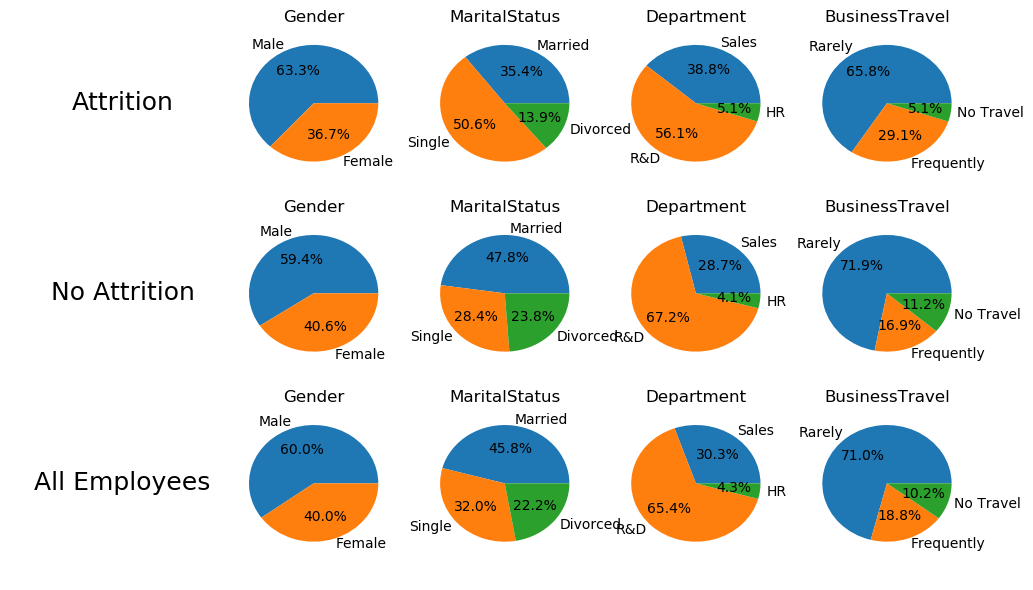

In [105]:
# Diagrammes en camembert de répartition de certaines caractéristiques dans la population
# Données sociologiques : Gender, MaritalStatus
# Données RH : Department, BusinessTravel

df0 = df[df['Attrition']=='Yes']
df1 = df[df['Attrition']=='No']
dA = [df0, df1, df]

fig = plt.figure(figsize=(10,6), dpi=100)
grid = gridspec.GridSpec(3,5)

plt.subplot(grid[0,0])
plt.axis('off')
plt.text(0.5,0.5, 'Attrition', ha='center', va='center', size = 18)

plt.subplot(grid[1,0])
plt.axis('off')
plt.text(0.5,0.5, 'No Attrition', ha='center', va='center', size = 18)

plt.subplot(grid[2,0])
plt.axis('off')
plt.text(0.5,0.5, 'All Employees', ha='center', va='center', size = 18)

i = 0
for d in dA:
   
    lab1 = ['Male','Female']
    frac1=[d[d['Gender']== 'Male'].shape[0],
          d[d['Gender']== 'Female'].shape[0]]

    lab2 = ['Married','Single','Divorced']
    frac2=[d[d['MaritalStatus']== 'Married'].shape[0],
          d[d['MaritalStatus']== 'Single'].shape[0],
          d[d['MaritalStatus']== 'Divorced'].shape[0]]

    lab3= ['Sales','R&D','HR']
    frac3=[d[d['Department']== 'Sales'].shape[0],
          d[d['Department']== 'Research & Development'].shape[0],
          d[d['Department']== 'Human Resources'].shape[0]]

    lab4 = ['Rarely','Frequently','No Travel']
    frac4=[d[d['BusinessTravel']== 'Travel_Rarely'].shape[0],
          d[d['BusinessTravel']== 'Travel_Frequently'].shape[0],
          d[d['BusinessTravel']== 'Non-Travel'].shape[0]]

    plt.subplot(grid[i,1])
    plt.pie(frac1, labels=lab1, autopct='%1.1f%%')
    plt.title('Gender')

    plt.subplot(grid[i,2])
    plt.pie(frac2, labels=lab2, autopct='%1.1f%%')
    plt.title('MaritalStatus')

    plt.subplot(grid[i,3])
    plt.pie(frac3, labels=lab3, autopct='%1.1f%%')
    plt.title('Department')

    plt.subplot(grid[i,4])
    plt.pie(frac4, labels=lab4, autopct='%1.1f%%')
    plt.title('BusinessTravel')
    
    i += 1 

plt.tight_layout()
plt.show()


# Le plus flagrant : les personnes célibataires sont plus susceptibles de partir que les personnes mariées
# les hommes ont un peu plus tendance à partir que les femmes
# le département le plus concerné par les départs est le département des Sales, ensuite les RH
# les personnes partant fréquemment en voyages d'affaire sont plus susceptibles de partir


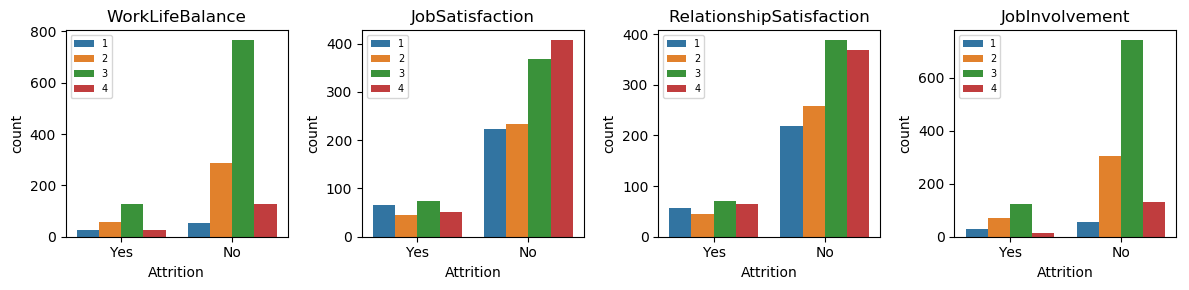

In [104]:
# Variables discrètes - diagrammes en bar
# Qualité de vie : WorkLifeBalance, JobInvolvement, JobSatisfaction, , RelationshipSatisfaction

fig = plt.figure(figsize=(12,3), dpi=100)
grid = gridspec.GridSpec(1,4)

col = ['WorkLifeBalance','JobSatisfaction', 'RelationshipSatisfaction','JobInvolvement']
i = 0

for c in col:
    plt.subplot(grid[0,i])
    sns.countplot(x= 'Attrition', hue = c, data= df)
    plt.title(c)
    plt.legend(prop={'size':7})
    i +=1

plt.tight_layout()
plt.show()

# l'équilibre de vie n'a pas l'air d'être déterminant dans le départ
# Par contre la satisfaction du travail et des relations l'est
# la plupart des gens partant sont impliqués dans leur travail

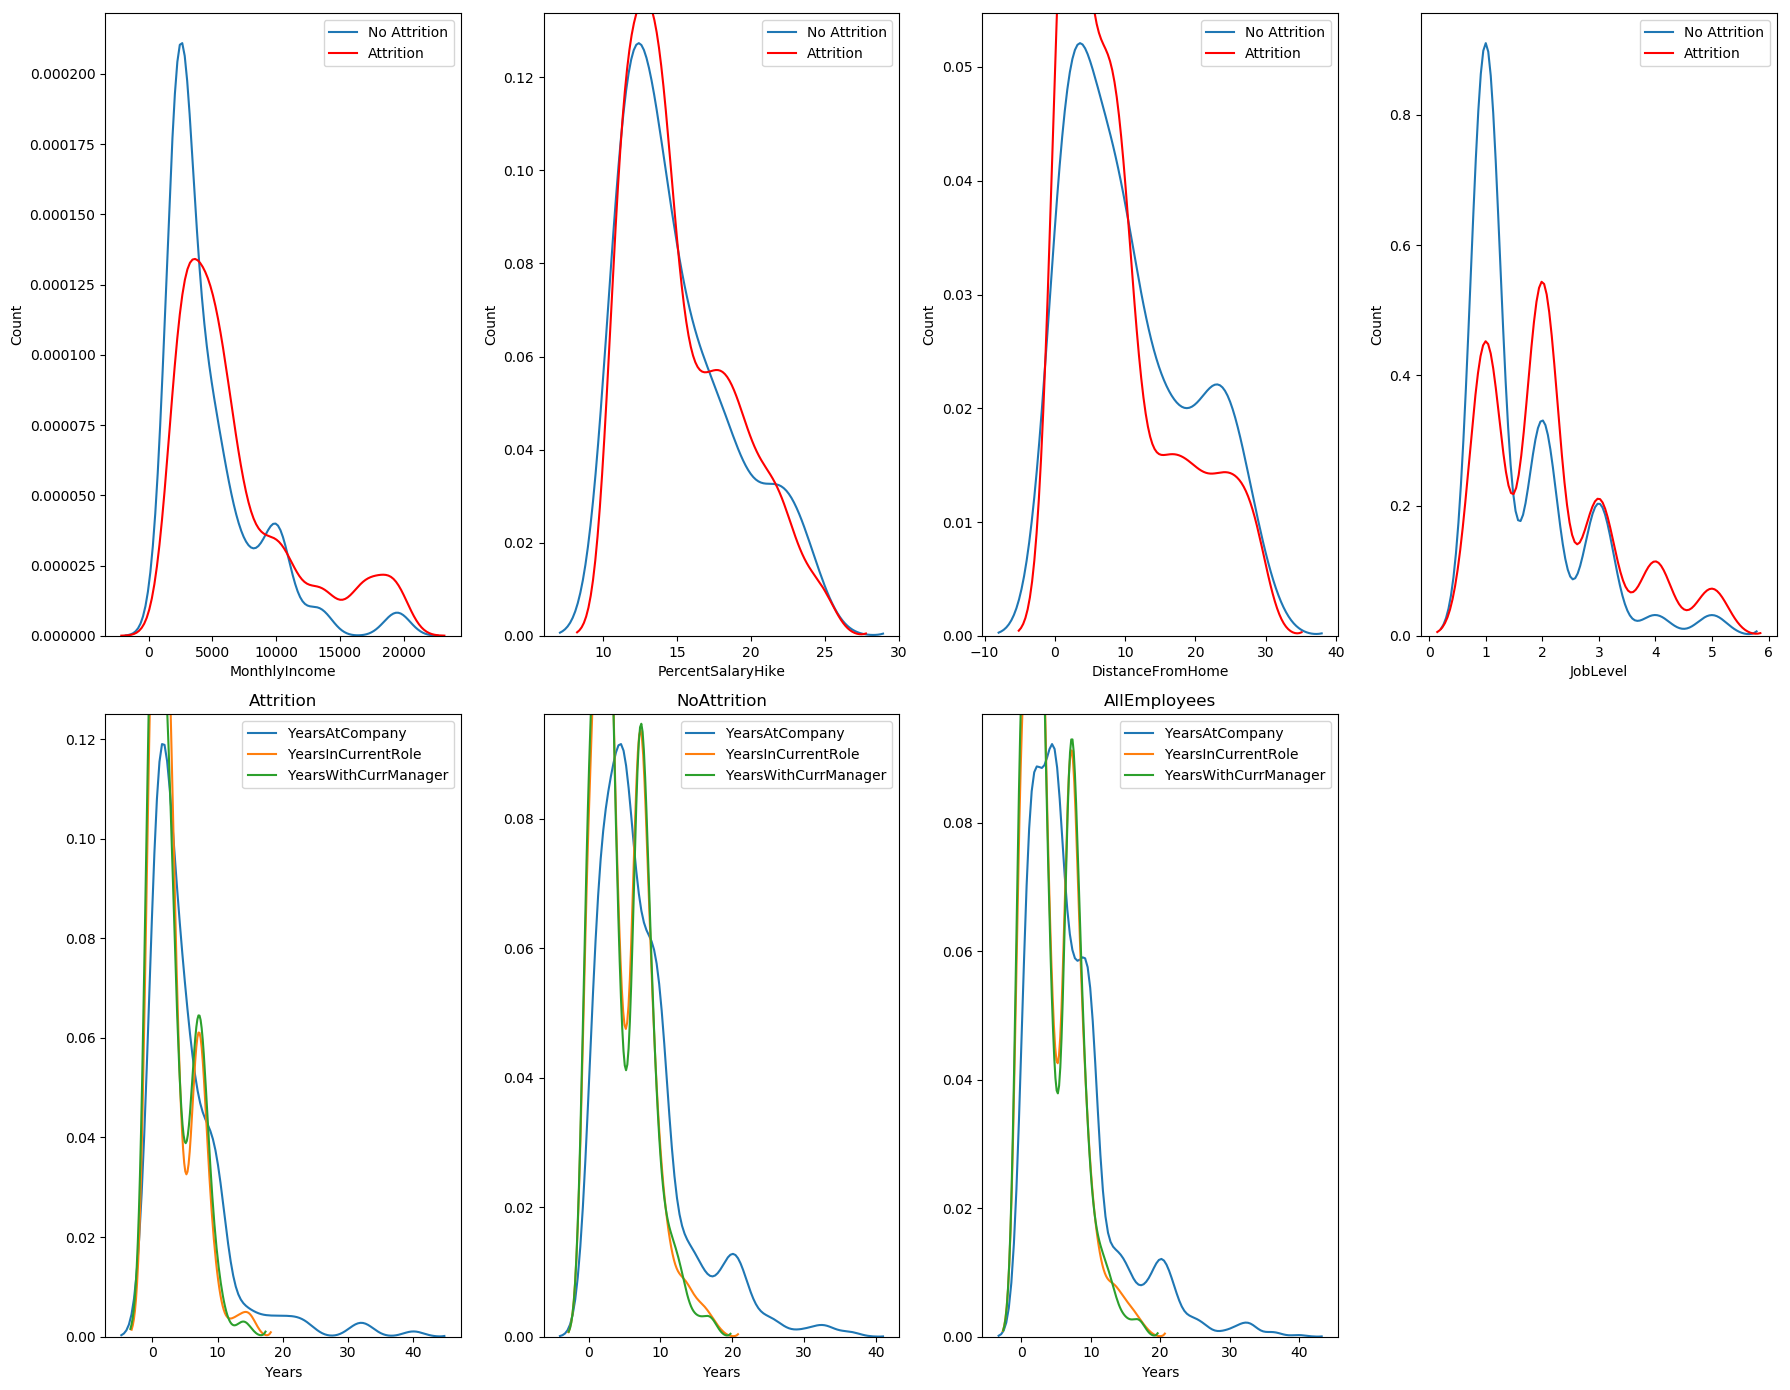

In [88]:
# Variables quantitatives
# MonthlyIncome, PercentSalaryHike, PerformanceRating, DistanceFromHome
# Ancienneté : YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager, JobLevel

fig = plt.figure(figsize=(18,14), dpi=100)
grid = gridspec.GridSpec(2,4)

col = ['MonthlyIncome','PercentSalaryHike', 'DistanceFromHome', 'JobLevel']
i = 0
for c in col:
    plt.subplot(grid[0,i])
    sns.distplot(df0[c], kde = True, hist = False, label = 'No Attrition')
    sns.distplot(df1[c], kde = True, color = 'red', hist = False, label = 'Attrition')
    plt.ylabel('Count')
    i +=1

title = ['Attrition','NoAttrition','AllEmployees']
j = 0
for d in dA:
    plt.subplot(grid[1,j])
    sns.distplot(d['YearsAtCompany'], kde = True, hist = False, label = 'YearsAtCompany')
    sns.distplot(d['YearsInCurrentRole'], kde = True, hist = False, label = 'YearsInCurrentRole')
    sns.distplot(d['YearsWithCurrManager'], kde = True, hist = False, label = 'YearsWithCurrManager')
    plt.legend(prop={'size':10}, loc=1)
    plt.xlabel('Years')
    plt.title(title[j])
    j +=1

plt.tight_layout()
plt.show()


In [94]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

# Logistic Regression


In [113]:
# Création de variables binomiales pour remplacer certaines variables qualitatives

df['Gender_int'] = pd.get_dummies(df['Gender'], drop_first = True)
df['OverTime_int'] = pd.get_dummies(df['OverTime'], drop_first = True)
df['Attrition_int'] = pd.get_dummies(df['Attrition'], drop_first = True)

#Correspondance Variances
corres1 = ['Attrition','Attrition_int']
corres2 = ['Gender', 'Gender_int']
corres3 = ['OverTime','OverTime_int']

print(df[corres1].drop_duplicates())
print(df[corres2].drop_duplicates())
print(df[corres3].drop_duplicates())

  Attrition  Attrition_int
0       Yes              1
1        No              0
   Gender  Gender_int
0  Female           0
1    Male           1
  OverTime  OverTime_int
0      Yes             1
1       No             0


In [114]:
# DataFrame Clean - avec colonnes en moins
col = ['Attrition','BusinessTravel','Department','Department','Education','EducationField','EmployeeCount', 'EmployeeNumber','EnvironmentSatisfaction','Gender','HourlyRate','JobRole','MaritalStatus', 'MonthlyRate','NumCompaniesWorked','Over18', 'OverTime','RelationshipSatisfaction', 'StandardHours', 'YearsInCurrentRole', 'YearsWithCurrManager']
dfc = df.drop(col, 1)

print(dfc.columns)
print(dfc.shape)


Index(['Age', 'DailyRate', 'DistanceFromHome', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'PercentSalaryHike',
       'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'Attrition_int', 'Gender_int',
       'OverTime_int'],
      dtype='object')
(1470, 18)


In [112]:
# Couper la base de donnée en 2 :training_set/test_set

X = dfc.iloc[]

train, test = train_test_split(dfc, train_size=0.8)

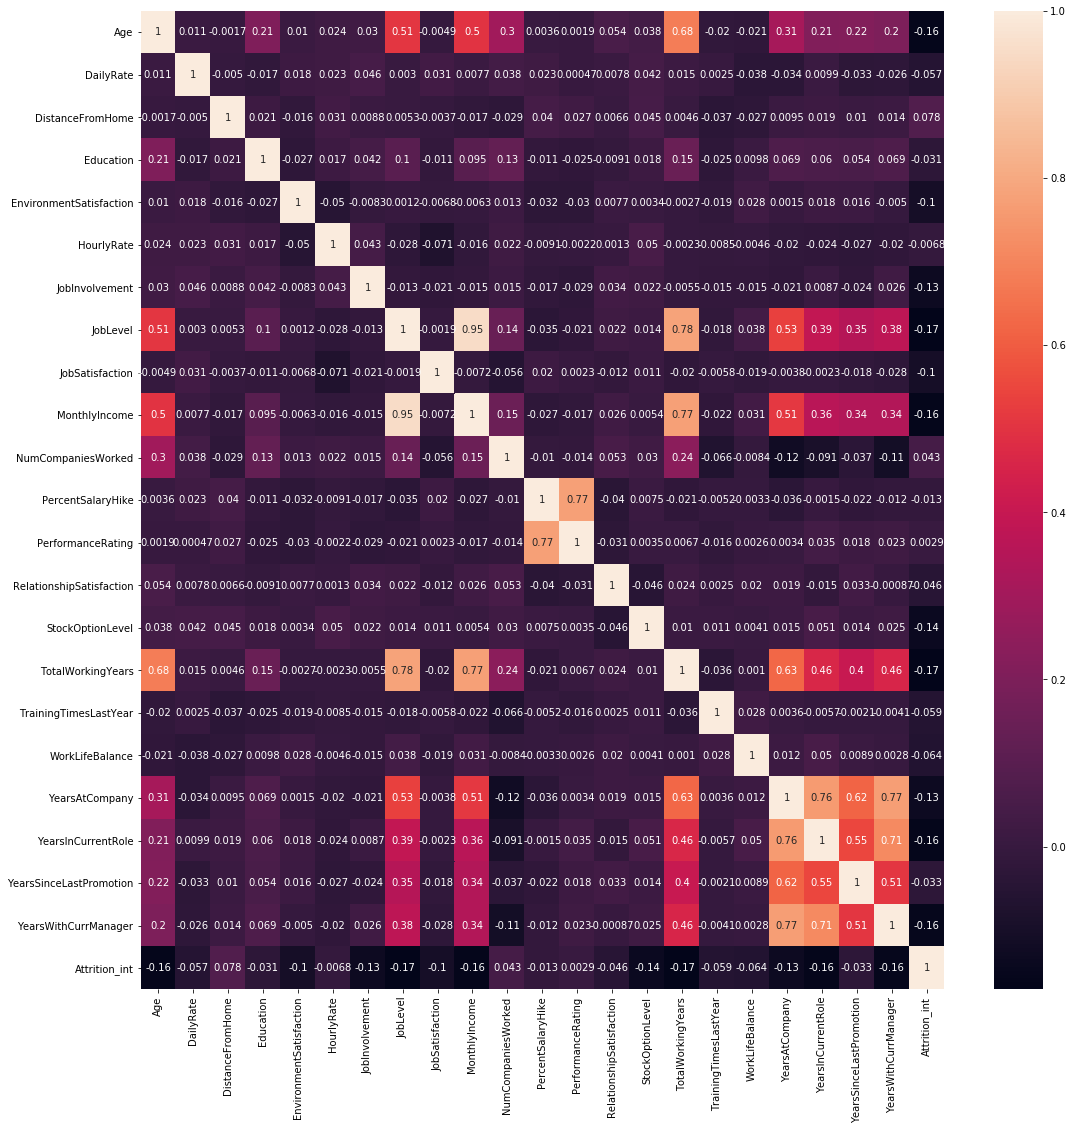

In [263]:
#####################BROUILLON

#Matrice de corrélation - transformer Attrition en int

fig2,ax2 = plt.subplots(figsize=(18, 18))
sns.heatmap(dfc.corr(), annot = True) 

## BEAUCOUP TROP GROS,le but est d'avoir une matrice plutôt claire en ne gardant que les facteurs intéressants
